In [21]:
# ## 0. Install Required Libraries (Run this first!)

# %%
# Install required packages if not already installed
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'wordcloud', 'plotly']

print("Checking and installing required packages...")
for package in required_packages:
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)
        print(f"✓ {package} installed successfully")

print("\nAll required packages are installed!")

Checking and installing required packages...
✓ pandas is already installed
✓ numpy is already installed
✓ matplotlib is already installed
✓ seaborn is already installed
✓ wordcloud is already installed
✓ plotly is already installed

All required packages are installed!


In [22]:
# ## 1. Import Libraries and Setup

# %%
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Try importing wordcloud
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    print("Warning: WordCloud not available. Word cloud visualizations will be skipped.")
    WORDCLOUD_AVAILABLE = False

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [23]:
# ## 2. Load and Prepare Data

# %%
# Load the CSV file locally nowww
file_path = 'sentiment_results.csv'  # Change this to your actual file path
df = pd.read_csv(file_path)

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst 5 rows:")
df.head()

# %%
# Data preparation
# Convert date_time to datetime
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.day_name()

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics for numerical columns:")
df.describe()

Dataset shape: (1000, 13)

Columns: ['author', 'content', 'cleaned_content', 'sentiment_score', 'sentiment_label', 'subjectivity', 'content_length', 'date_time', 'language', 'country', 'number_of_likes', 'number_of_shares', 'id']

Data types:
author               object
content              object
cleaned_content      object
sentiment_score     float64
sentiment_label      object
subjectivity        float64
content_length        int64
date_time            object
language             object
country              object
number_of_likes       int64
number_of_shares      int64
id                    int64
dtype: object

First 5 rows:
Missing values:
author              0
content             0
cleaned_content     0
sentiment_score     0
sentiment_label     0
subjectivity        0
content_length      0
date_time           0
language            0
country             0
number_of_likes     0
number_of_shares    0
id                  0
date                0
hour                0
day_of_week       

,sentiment_score,subjectivity,content_length,number_of_likes,number_of_shares,id,hour
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.143548,0.314850,43.302000,4171.710000,616.745000,1670.887000,14.311000
std,0.319482,0.342028,9.211061,2026.787973,289.427854,468.847624,5.104345
min,-1.000000,0.000000,25.000000,234.000000,45.000000,1001.000000,0.000000
25%,0.000000,0.000000,38.000000,2345.000000,456.000000,1258.500000,10.000000
50%,0.000000,0.238636,42.000000,4567.000000,567.000000,1508.500000,14.000000
75%,0.300000,0.550379,47.000000,5678.000000,789.000000,2158.250000,19.000000
max,1.000000,1.000000,112.000000,8901.000000,2345.000000,2408.000000,23.000000


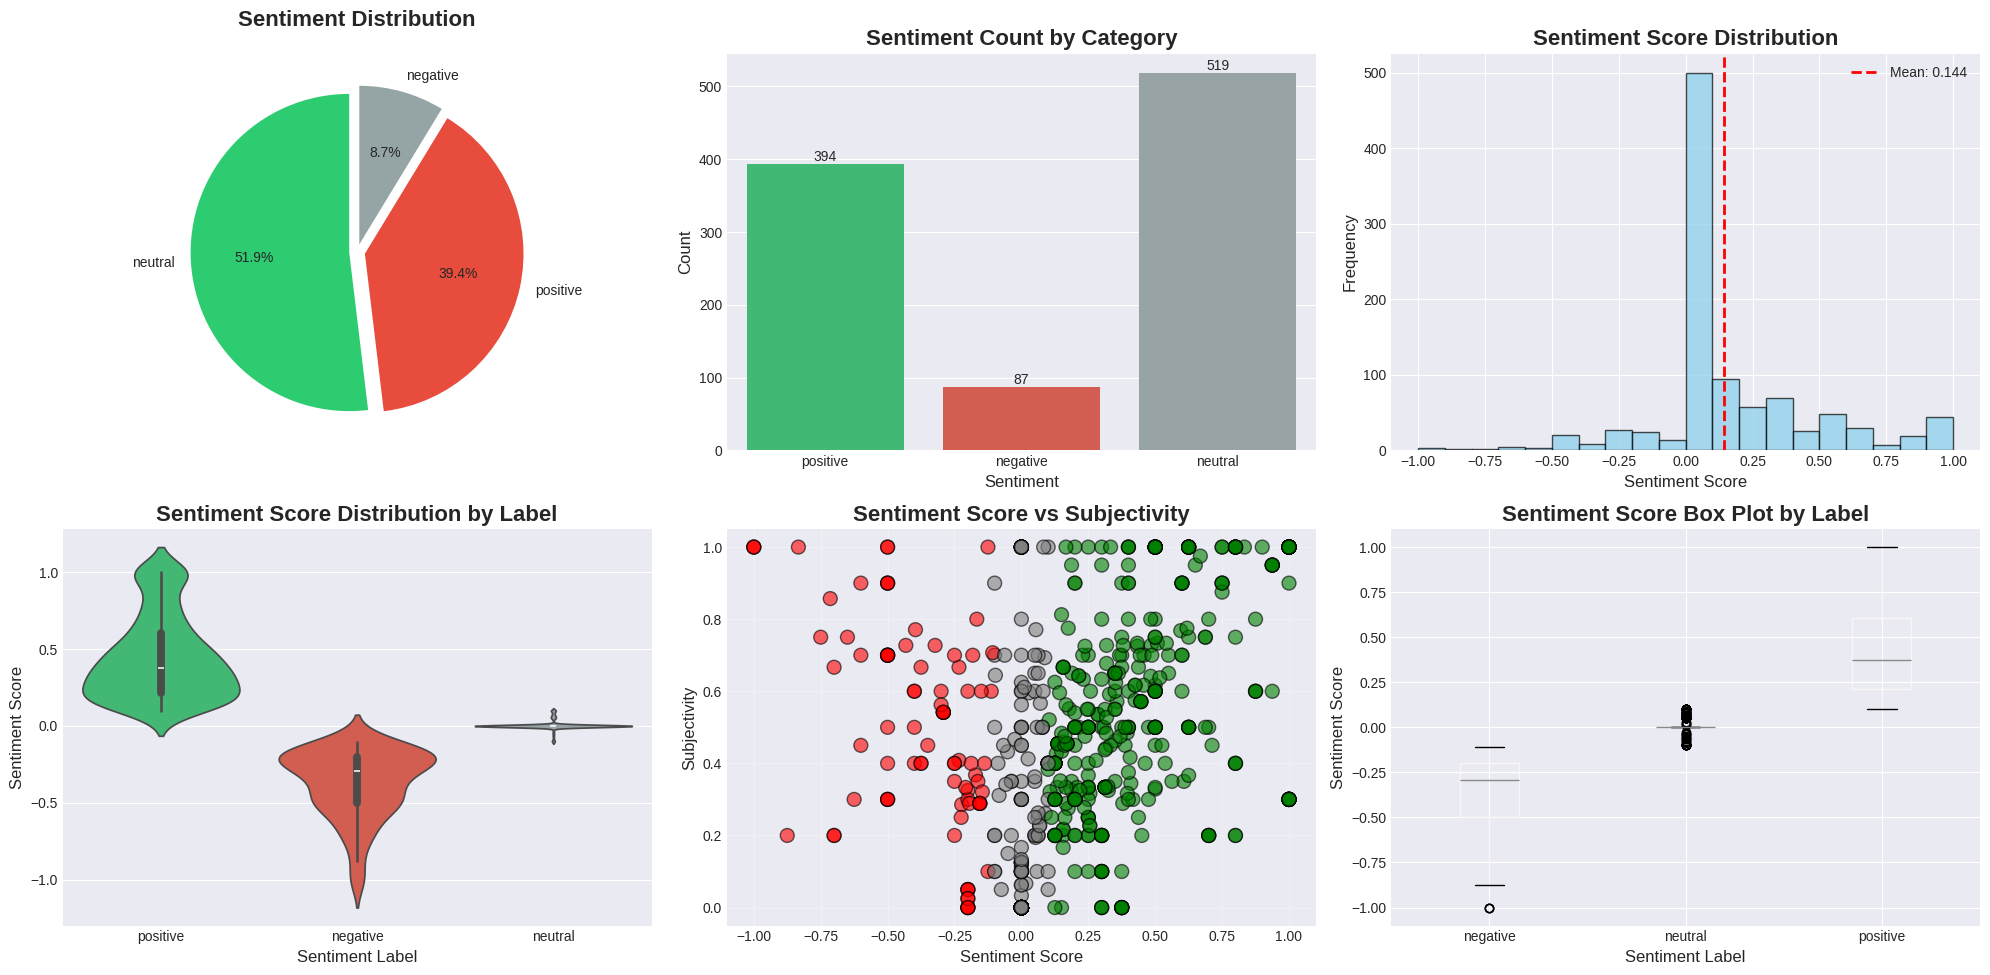

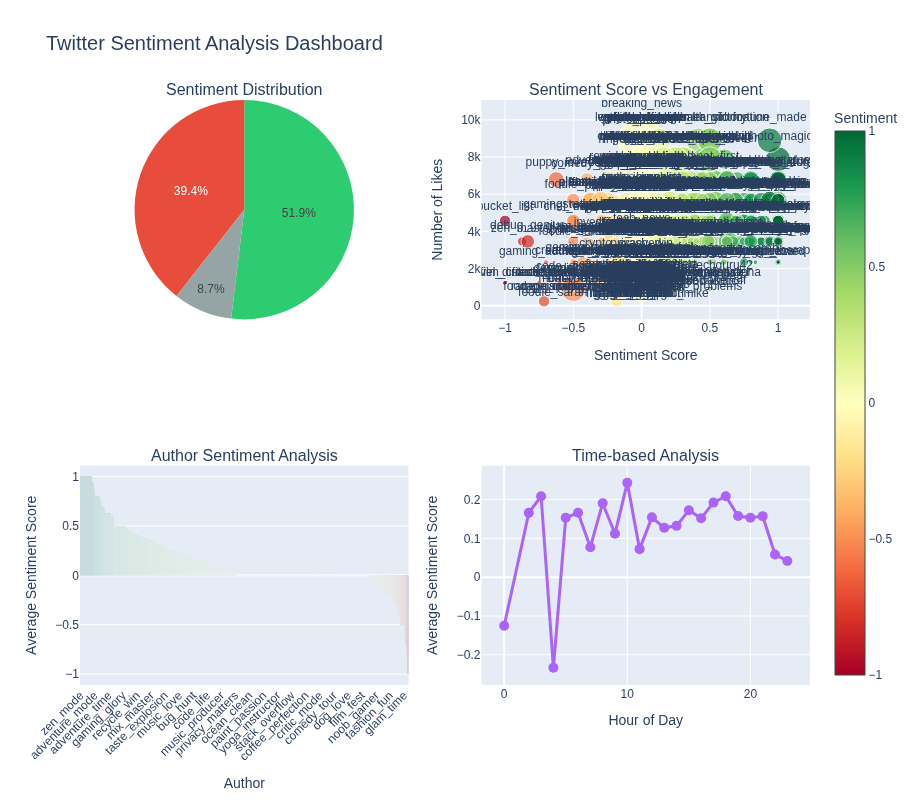

In [31]:
# ## 4. Interactive Visualizations with Plotly

# %%
# Create interactive sentiment analysis dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Sentiment Distribution', 'Sentiment Score vs Engagement',
                    'Author Sentiment Analysis', 'Time-based Analysis'),
    specs=[[{"type": "pie"}, {"type": "scatter"}],
           [{"type": "bar"}, {"type": "scatter"}]]
)

# 1. Pie chart
fig.add_trace(
    go.Pie(labels=sentiment_counts.index, values=sentiment_counts.values,
           marker_colors=['#2ecc71', '#e74c3c', '#95a5a6']),
    row=1, col=1
)

# 2. Sentiment vs Engagement
fig.add_trace(
    go.Scatter(x=df['sentiment_score'], y=df['number_of_likes'],
               mode='markers+text',
               text=df['author'],
               textposition="top center",
               marker=dict(size=df['number_of_shares']/50,
                          color=df['sentiment_score'],
                          colorscale='RdYlGn',
                          showscale=True,
                          colorbar=dict(title="Sentiment")),
               name='Tweets'),
    row=1, col=2
)

# 3. Author sentiment analysis
author_stats = df.groupby('author').agg({
    'sentiment_score': 'mean',
    'sentiment_label': lambda x: x.mode()[0] if not x.empty else 'neutral'
}).sort_values('sentiment_score', ascending=False)

fig.add_trace(
    go.Bar(x=author_stats.index, y=author_stats['sentiment_score'],
           marker_color=author_stats['sentiment_score'],
           marker_colorscale='RdYlGn',
           text=author_stats['sentiment_score'].round(3),
           textposition='outside'),
    row=2, col=1
)

# 4. Time-based analysis
hourly_sentiment = df.groupby('hour')['sentiment_score'].mean().reset_index()
fig.add_trace(
    go.Scatter(x=hourly_sentiment['hour'], y=hourly_sentiment['sentiment_score'],
               mode='lines+markers',
               line=dict(width=3),
               marker=dict(size=10)),
    row=2, col=2
)

# Update layout
fig.update_layout(height=800, showlegend=False,
                  title_text="Twitter Sentiment Analysis Dashboard",
                  title_font_size=20)
fig.update_xaxes(title_text="Sentiment Score", row=1, col=2)
fig.update_yaxes(title_text="Number of Likes", row=1, col=2)
fig.update_xaxes(title_text="Author", row=2, col=1, tickangle=-45)
fig.update_yaxes(title_text="Average Sentiment Score", row=2, col=1)
fig.update_xaxes(title_text="Hour of Day", row=2, col=2)
fig.update_yaxes(title_text="Average Sentiment Score", row=2, col=2)

fig.show()

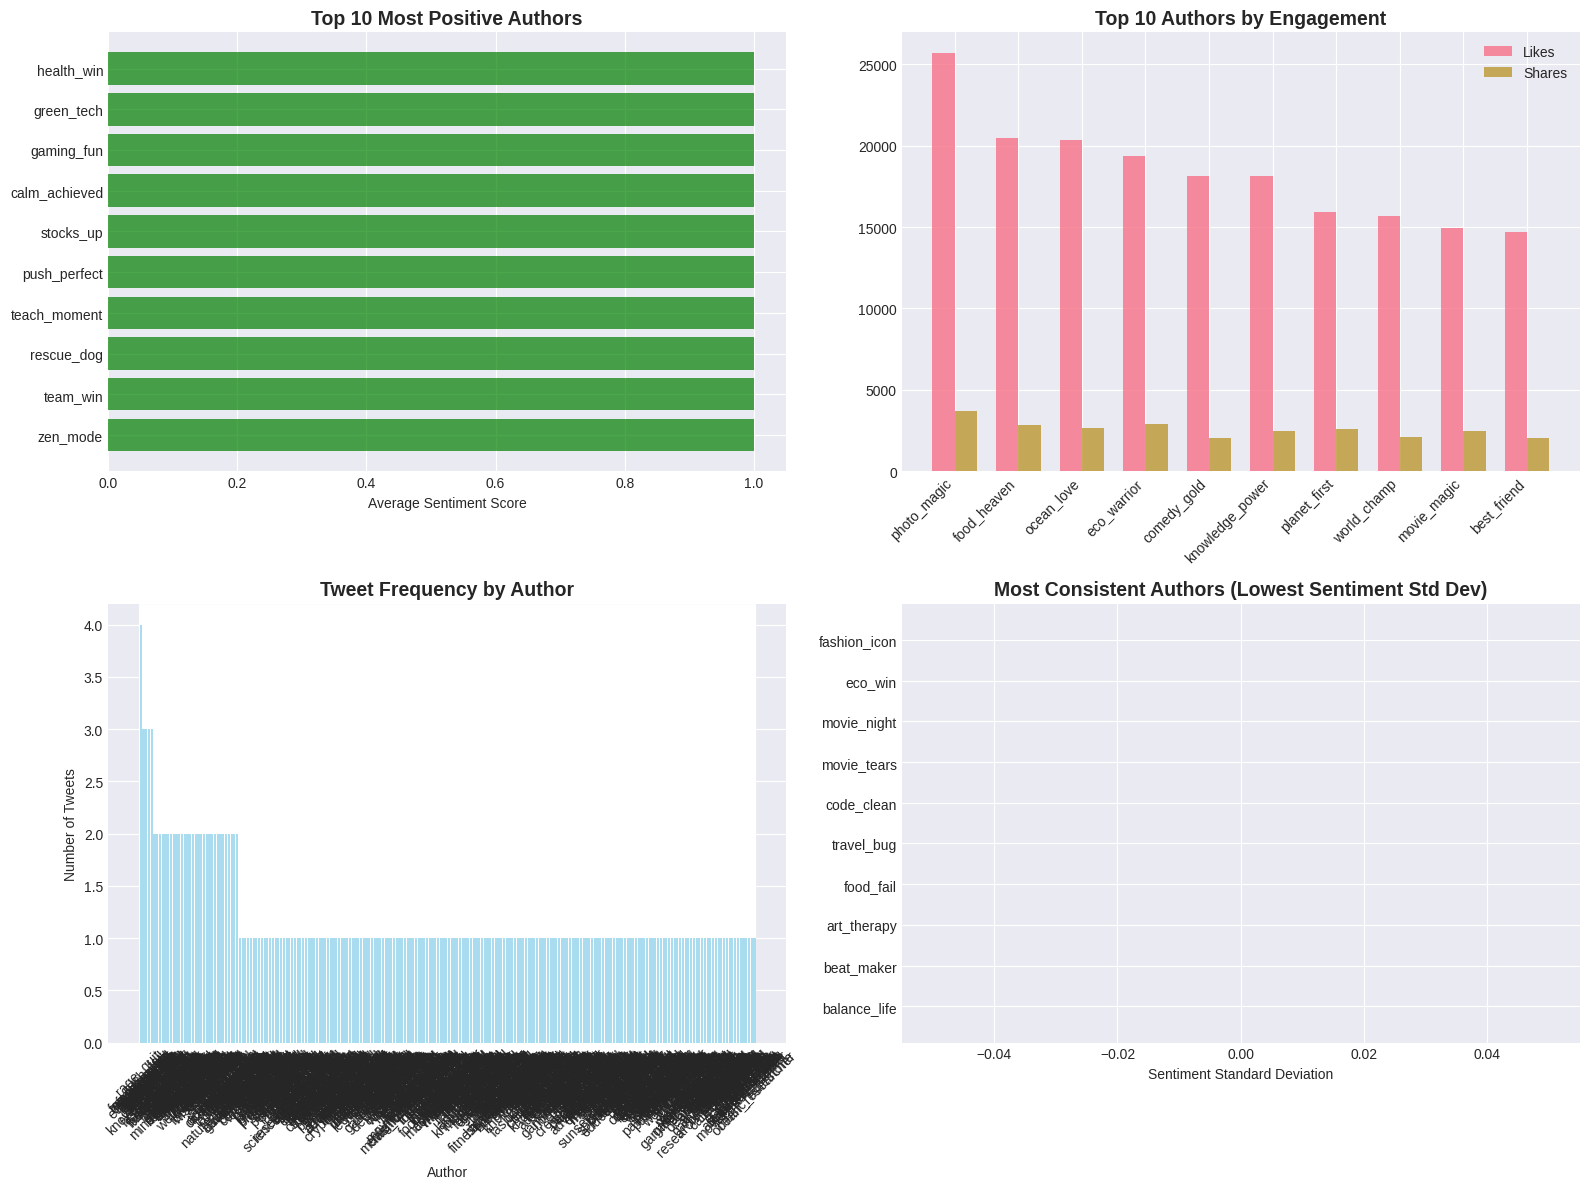


Author Analysis Summary:
                 avg_sentiment  std_sentiment  tweet_count  total_likes  \
author                                                                    
zen_mode                 1.000            NaN            1         3456   
team_win                 1.000            NaN            1         4567   
rescue_dog               1.000            NaN            1         6789   
teach_moment             1.000            NaN            1         3456   
push_perfect             1.000            NaN            1         3456   
...                        ...            ...          ...          ...   
foodie_fail             -0.750            NaN            1         1234   
debug_genius            -0.833            NaN            1         3456   
bucket_list             -1.000            NaN            1         4567   
travel_disaster         -1.000            NaN            1         1234   
film_critic             -1.000            NaN            1         1234   

In [26]:
# ## 5. Author Analysis

# %%
# Detailed author analysis
author_analysis = df.groupby('author').agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'number_of_likes': 'sum',
    'number_of_shares': 'sum',
    'sentiment_label': lambda x: x.value_counts().to_dict()
}).round(3)

author_analysis.columns = ['avg_sentiment', 'std_sentiment', 'tweet_count', 
                          'total_likes', 'total_shares', 'sentiment_distribution']
author_analysis = author_analysis.sort_values('avg_sentiment', ascending=False)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 most positive authors
ax1 = axes[0, 0]
top_positive = author_analysis.head(10)
ax1.barh(top_positive.index, top_positive['avg_sentiment'], color='green', alpha=0.7)
ax1.set_title('Top 10 Most Positive Authors', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average Sentiment Score')

# 2. Engagement by author
ax2 = axes[0, 1]
engagement_data = author_analysis.sort_values('total_likes', ascending=False).head(10)
x = np.arange(len(engagement_data))
width = 0.35
ax2.bar(x - width/2, engagement_data['total_likes'], width, label='Likes', alpha=0.8)
ax2.bar(x + width/2, engagement_data['total_shares'], width, label='Shares', alpha=0.8)
ax2.set_title('Top 10 Authors by Engagement', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(engagement_data.index, rotation=45, ha='right')
ax2.legend()

# 3. Author tweet frequency
ax3 = axes[1, 0]
tweet_freq = author_analysis.sort_values('tweet_count', ascending=False)
ax3.bar(tweet_freq.index, tweet_freq['tweet_count'], color='skyblue', alpha=0.7)
ax3.set_title('Tweet Frequency by Author', fontsize=14, fontweight='bold')
ax3.set_xlabel('Author')
ax3.set_ylabel('Number of Tweets')
ax3.tick_params(axis='x', rotation=45)

# 4. Sentiment consistency (std)
ax4 = axes[1, 1]
consistency = author_analysis.sort_values('std_sentiment', ascending=True).head(10)
ax4.barh(consistency.index, consistency['std_sentiment'], color='purple', alpha=0.7)
ax4.set_title('Most Consistent Authors (Lowest Sentiment Std Dev)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Sentiment Standard Deviation')

plt.tight_layout()
plt.show()

print("\nAuthor Analysis Summary:")
print(author_analysis)

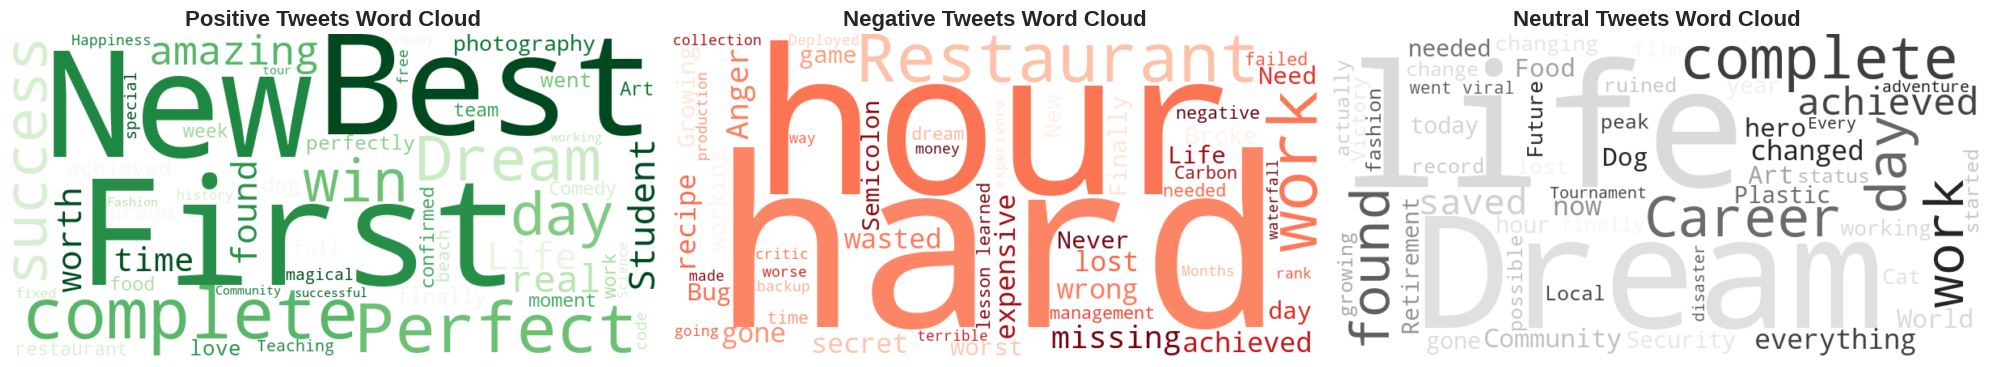

In [27]:
# ## 6. Word Cloud Analysis

# %%
if WORDCLOUD_AVAILABLE:
    # Create word clouds for different sentiments
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    sentiments = ['positive', 'negative', 'neutral']
    colors = ['Greens', 'Reds', 'Greys']

    for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
        # Get text for specific sentiment
        sentiment_text = ' '.join(df[df['sentiment_label'] == sentiment]['cleaned_content'].dropna())
        
        if sentiment_text:  # Check if there's text to process
            # Create word cloud
            wordcloud = WordCloud(width=800, height=400, 
                                background_color='white',
                                colormap=color,
                                max_words=50).generate(sentiment_text)
            
            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].set_title(f'{sentiment.capitalize()} Tweets Word Cloud', 
                               fontsize=16, fontweight='bold')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f'No {sentiment} tweets', 
                          ha='center', va='center', fontsize=14)
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("WordCloud library not available. Showing alternative visualization...")
    
    # Alternative: Show most common words for each sentiment
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    sentiments = ['positive', 'negative', 'neutral']
    colors = ['green', 'red', 'gray']
    
    for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
        # Get text for specific sentiment
        sentiment_df = df[df['sentiment_label'] == sentiment]
        
        if len(sentiment_df) > 0:
            # Count word frequencies
            all_words = ' '.join(sentiment_df['cleaned_content'].dropna()).lower().split()
            word_freq = pd.Series(all_words).value_counts().head(20)
            
            # Create bar plot
            axes[idx].barh(word_freq.index[::-1], word_freq.values[::-1], color=color, alpha=0.7)
            axes[idx].set_title(f'Top Words in {sentiment.capitalize()} Tweets', 
                               fontsize=16, fontweight='bold')
            axes[idx].set_xlabel('Frequency')
        else:
            axes[idx].text(0.5, 0.5, f'No {sentiment} tweets', 
                          ha='center', va='center', fontsize=14)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

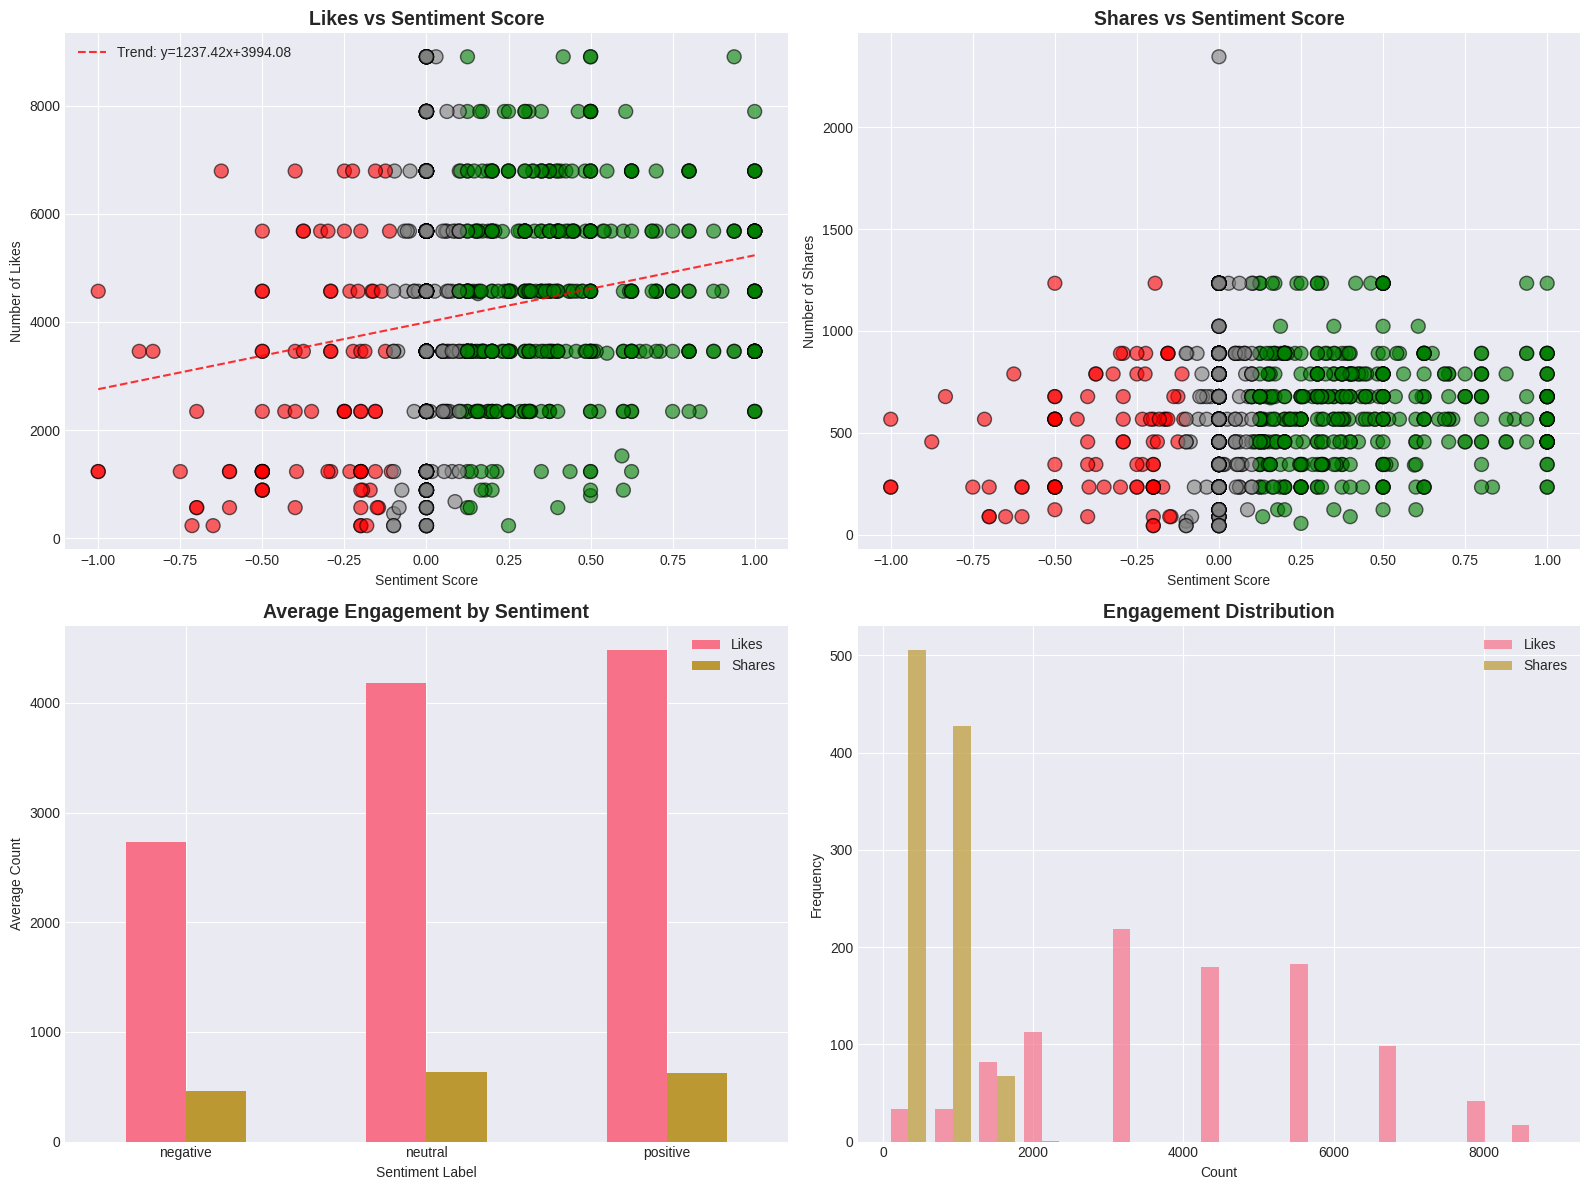

Engagement Statistics by Sentiment:
                number_of_likes                                           \
                          count         mean          std    min     25%   
sentiment_label                                                            
negative                   87.0  2733.712644  1992.540215  234.0  1234.0   
neutral                   519.0  4179.285164  2114.529495  234.0  2345.0   
positive                  394.0  4479.258883  1768.414365  234.0  3456.0   

                                        number_of_shares              \
                    50%     75%     max            count        mean   
sentiment_label                                                        
negative         2345.0  4567.0  6789.0             87.0  463.057471   
neutral          4567.0  5678.0  8901.0            519.0  636.660886   
positive         4567.0  5678.0  8901.0            394.0  624.446701   

                                                                
         

In [28]:
# ## 7. Engagement Analysis

# %%
# Engagement vs Sentiment Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Likes vs Sentiment Score
ax1 = axes[0, 0]
ax1.scatter(df['sentiment_score'], df['number_of_likes'], 
           c=df['sentiment_label'].map({'positive': 'green', 'negative': 'red', 'neutral': 'gray'}),
           s=100, alpha=0.6, edgecolors='black')
ax1.set_title('Likes vs Sentiment Score', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment Score')
ax1.set_ylabel('Number of Likes')

# Add trend line
z = np.polyfit(df['sentiment_score'], df['number_of_likes'], 1)
p = np.poly1d(z)
ax1.plot(df['sentiment_score'].sort_values(), p(df['sentiment_score'].sort_values()), 
         "r--", alpha=0.8, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
ax1.legend()

# 2. Shares vs Sentiment Score
ax2 = axes[0, 1]
ax2.scatter(df['sentiment_score'], df['number_of_shares'],
           c=df['sentiment_label'].map({'positive': 'green', 'negative': 'red', 'neutral': 'gray'}),
           s=100, alpha=0.6, edgecolors='black')
ax2.set_title('Shares vs Sentiment Score', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sentiment Score')
ax2.set_ylabel('Number of Shares')

# 3. Average engagement by sentiment
ax3 = axes[1, 0]
engagement_by_sentiment = df.groupby('sentiment_label').agg({
    'number_of_likes': 'mean',
    'number_of_shares': 'mean'
})
engagement_by_sentiment.plot(kind='bar', ax=ax3)
ax3.set_title('Average Engagement by Sentiment', fontsize=14, fontweight='bold')
ax3.set_xlabel('Sentiment Label')
ax3.set_ylabel('Average Count')
ax3.legend(['Likes', 'Shares'])
ax3.tick_params(axis='x', rotation=0)

# 4. Engagement distribution
ax4 = axes[1, 1]
ax4.hist([df['number_of_likes'], df['number_of_shares']], 
         bins=15, label=['Likes', 'Shares'], alpha=0.7)
ax4.set_title('Engagement Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Count')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.show()

# Print engagement statistics
print("Engagement Statistics by Sentiment:")
print(df.groupby('sentiment_label')[['number_of_likes', 'number_of_shares']].describe())

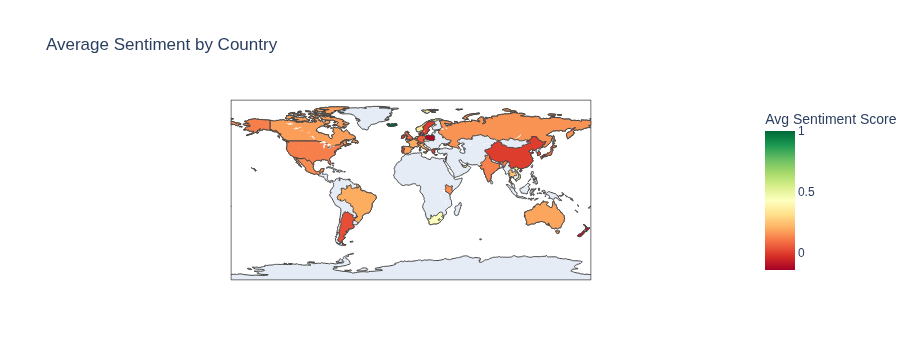

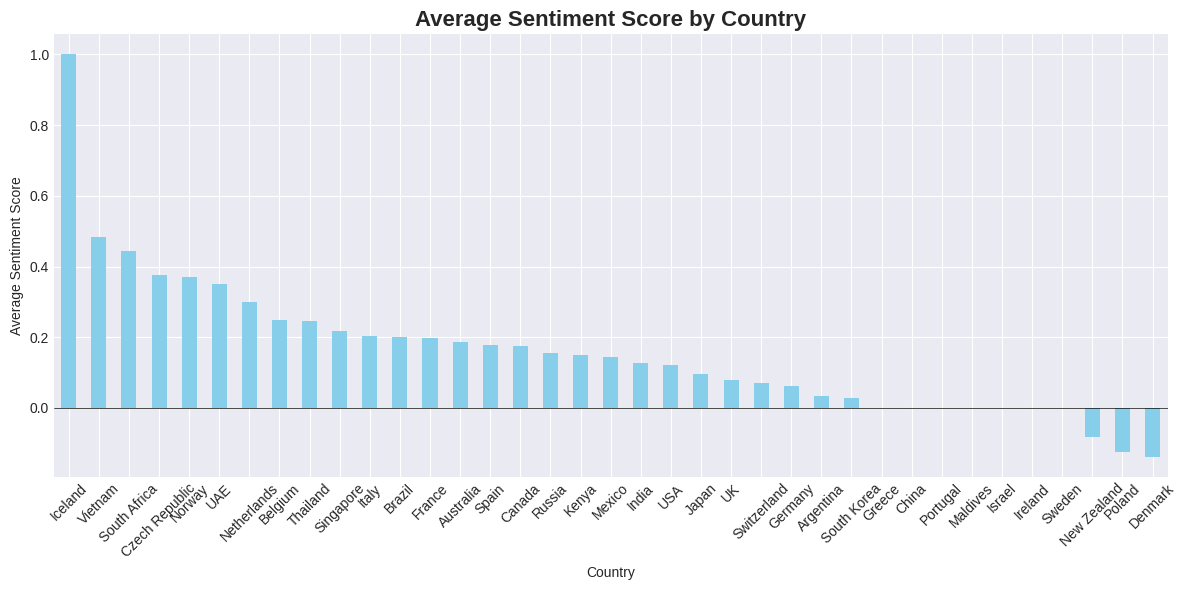

In [29]:
# ## 8. Geographic Analysis

# %%
# Geographic sentiment analysis
if 'country' in df.columns:
    # Country-wise sentiment analysis
    country_sentiment = df.groupby('country').agg({
        'sentiment_score': ['mean', 'count'],
        'number_of_likes': 'sum',
        'sentiment_label': lambda x: x.value_counts().to_dict()
    })
    country_sentiment.columns = ['avg_sentiment', 'tweet_count', 'total_likes', 'sentiment_dist']
    country_sentiment = country_sentiment.sort_values('avg_sentiment', ascending=False)
    
    # Create world map visualization using plotly
    fig = px.choropleth(country_sentiment.reset_index(), 
                        locations='country',
                        locationmode='country names',
                        color='avg_sentiment',
                        hover_data=['tweet_count', 'total_likes'],
                        color_continuous_scale='RdYlGn',
                        title='Average Sentiment by Country',
                        labels={'avg_sentiment': 'Avg Sentiment Score'})
    fig.show()
    
    # Bar chart of sentiment by country
    plt.figure(figsize=(12, 6))
    country_sentiment['avg_sentiment'].plot(kind='bar', color='skyblue')
    plt.title('Average Sentiment Score by Country', fontsize=16, fontweight='bold')
    plt.xlabel('Country')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()

STATISTICAL ANALYSIS SUMMARY

1. Overall Sentiment Statistics:
   - Mean Sentiment Score: 0.1435
   - Median Sentiment Score: 0.0000
   - Standard Deviation: 0.3195
   - Skewness: 0.6568
   - Kurtosis: 1.5522

2. Sentiment Distribution:
   - Neutral: 519 (51.9%)
   - Positive: 394 (39.4%)
   - Negative: 87 (8.7%)

3. Engagement Statistics:
   - Total Likes: 4,171,710
   - Total Shares: 616,745
   - Average Likes per Tweet: 4171.7
   - Average Shares per Tweet: 616.7

4. Correlation Analysis:
                  sentiment_score  subjectivity  number_of_likes  \
sentiment_score          1.000000      0.429848         0.195054   
subjectivity             0.429848      1.000000         0.004631   
number_of_likes          0.195054      0.004631         1.000000   
number_of_shares         0.091093     -0.027045         0.815513   

                  number_of_shares  
sentiment_score           0.091093  
subjectivity             -0.027045  
number_of_likes           0.815513  
number_of_shar

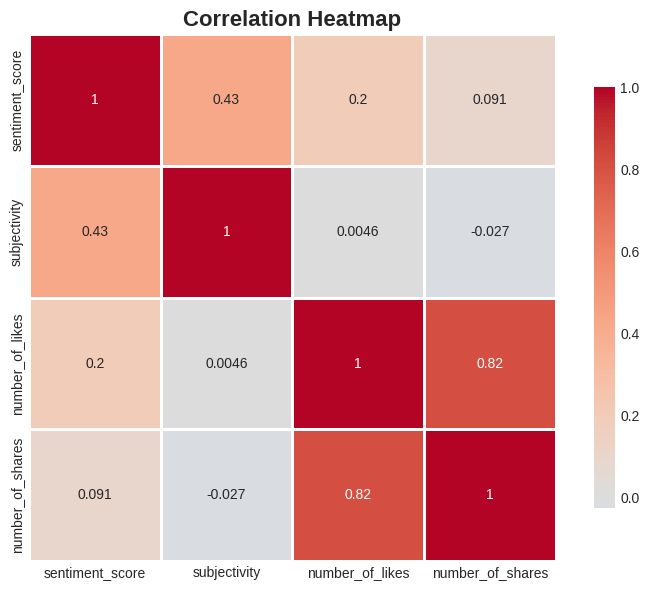

In [30]:
# ## 9. Statistical Analysis

# %%
# Statistical summary
print("STATISTICAL ANALYSIS SUMMARY")
print("="*50)

# Overall statistics
print("\n1. Overall Sentiment Statistics:")
print(f"   - Mean Sentiment Score: {df['sentiment_score'].mean():.4f}")
print(f"   - Median Sentiment Score: {df['sentiment_score'].median():.4f}")
print(f"   - Standard Deviation: {df['sentiment_score'].std():.4f}")
print(f"   - Skewness: {df['sentiment_score'].skew():.4f}")
print(f"   - Kurtosis: {df['sentiment_score'].kurtosis():.4f}")

# Sentiment distribution
print("\n2. Sentiment Distribution:")
for sentiment, count in df['sentiment_label'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"   - {sentiment.capitalize()}: {count} ({percentage:.1f}%)")

# Engagement statistics
print("\n3. Engagement Statistics:")
print(f"   - Total Likes: {df['number_of_likes'].sum():,}")
print(f"   - Total Shares: {df['number_of_shares'].sum():,}")
print(f"   - Average Likes per Tweet: {df['number_of_likes'].mean():.1f}")
print(f"   - Average Shares per Tweet: {df['number_of_shares'].mean():.1f}")

# Correlation analysis
print("\n4. Correlation Analysis:")
correlation = df[['sentiment_score', 'subjectivity', 'number_of_likes', 'number_of_shares']].corr()
print(correlation)

# Create correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()